<h2>1.1 Importing Relevant Libraries</h2>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
from sklearn.metrics import mean_absolute_error
import catboost as catt
import optuna
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import log_loss,roc_auc_score,accuracy_score, f1_score
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/incident_event_log.csv
/kaggle/input/Incident_response.txt


In [6]:
train_dataset = pd.read_csv("/kaggle/input/incident_event_log.csv")

In [7]:
# check first 5 columns in the dataset
train_dataset.head(5)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


<h2>1.2 EDA AND DATA CLEANING</h2>

In [8]:
train_dataset.shape

(119998, 36)

In [9]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119998 entries, 0 to 119997
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   119998 non-null  object
 1   incident_state           119998 non-null  object
 2   active                   119998 non-null  bool  
 3   reassignment_count       119998 non-null  int64 
 4   reopen_count             119998 non-null  int64 
 5   sys_mod_count            119998 non-null  int64 
 6   made_sla                 119998 non-null  bool  
 7   caller_id                119998 non-null  object
 8   opened_by                119998 non-null  object
 9   opened_at                119998 non-null  object
 10  sys_created_by           119998 non-null  object
 11  sys_created_at           119998 non-null  object
 12  sys_updated_by           119998 non-null  object
 13  sys_updated_at           119998 non-null  object
 14  contact_type        

In [10]:
train_dataset.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at'],
      dtype='object')

In [11]:
train_dataset.replace("?", np.NaN, inplace=True)

In [12]:
# This are where null values are
train_dataset.isnull().sum()

number                          0
incident_state                  0
active                          0
reassignment_count              0
reopen_count                    0
sys_mod_count                   0
made_sla                        0
caller_id                      29
opened_by                    4835
opened_at                       0
sys_created_by              42354
sys_created_at              42354
sys_updated_by                  0
sys_updated_at                  0
contact_type                    0
location                       76
category                       64
subcategory                    97
u_symptom                   28271
cmdb_ci                    119562
impact                          0
urgency                         0
priority                        0
assignment_group            14213
assigned_to                 23030
knowledge                       0
u_priority_confirmation         0
notify                          0
problem_id                 118061
rfc           

In [13]:
train_dataset["resolved_by"].value_counts()

resolved_by
Resolved by 15     14398
Resolved by 11      9864
Resolved by 53      3381
Resolved by 177     3226
Resolved by 62      3186
                   ...  
Resolved by 187        5
Resolved by 228        4
Resolved by 48         3
Resolved by 186        3
Resolved by 97         3
Name: count, Length: 190, dtype: int64

In [14]:
mode = train_dataset["resolved_by"].mode()[0]
train_dataset['resolved_by'] = train_dataset['resolved_by'].fillna(mode)

In [15]:
mode = train_dataset["closed_code"].mode()[0]
train_dataset['closed_code'] = train_dataset['closed_code'].fillna(mode)

In [16]:
columns_to_drop =['problem_id', 'rfc', 'vendor','caused_by','sys_created_at','sys_created_by', 'notify',"assigned_to","cmdb_ci","caller_id","u_symptom"]
train_dataset = train_dataset.drop(columns_to_drop, axis=1)

In [17]:
train_dataset["reassignment_count"].value_counts()

reassignment_count
0     57377
1     32183
2     12961
3      7274
4      4091
5      2310
6      1315
7       900
8       506
9       341
10      272
11      165
12      100
13       57
14       38
15       21
17       16
20       16
16       13
18       13
22        9
19        8
21        3
27        3
23        2
26        2
24        1
25        1
Name: count, dtype: int64

In [18]:
train_dataset.head(5)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,opened_by,opened_at,sys_updated_by,...,impact,urgency,priority,assignment_group,knowledge,u_priority_confirmation,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Opened by 8,29/2/2016 01:16,Updated by 21,...,2 - Medium,2 - Medium,3 - Moderate,Group 56,True,False,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Opened by 8,29/2/2016 01:16,Updated by 642,...,2 - Medium,2 - Medium,3 - Moderate,Group 56,True,False,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Opened by 8,29/2/2016 01:16,Updated by 804,...,2 - Medium,2 - Medium,3 - Moderate,Group 56,True,False,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Opened by 8,29/2/2016 01:16,Updated by 908,...,2 - Medium,2 - Medium,3 - Moderate,Group 56,True,False,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Opened by 397,29/2/2016 04:40,Updated by 746,...,2 - Medium,2 - Medium,3 - Moderate,Group 70,True,False,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


In [19]:
train_dataset["location"].value_counts()

location
Location 204    27153
Location 161    18433
Location 143    16129
Location 108    10635
Location 93     10093
                ...  
Location 227        3
Location 137        3
Location 164        3
Location 31         2
Location 166        2
Name: count, Length: 202, dtype: int64

In [20]:
train_dataset["contact_type"].value_counts()

contact_type
Phone    119879
Email       119
Name: count, dtype: int64

In [21]:
train_dataset["incident_state"].value_counts()

incident_state
Active                33582
New                   30229
Resolved              21500
Closed                20825
Awaiting User Info    12884
Awaiting Vendor         557
Awaiting Problem        400
Awaiting Evidence        19
-100                      2
Name: count, dtype: int64

In [22]:
train_dataset = train_dataset[train_dataset['incident_state'] != "-100"]


In [23]:
train_dataset.shape

(119996, 25)

In [24]:
train_dataset.isnull().sum()

number                         0
incident_state                 0
active                         0
reassignment_count             0
reopen_count                   0
sys_mod_count                  0
made_sla                       0
opened_by                   4835
opened_at                      0
sys_updated_by                 0
sys_updated_at                 0
contact_type                   0
location                      76
category                      64
subcategory                   97
impact                         0
urgency                        0
priority                       0
assignment_group           14213
knowledge                      0
u_priority_confirmation        0
closed_code                    0
resolved_by                    0
resolved_at                 2861
closed_at                      0
dtype: int64

In [25]:
percent_missing = train_dataset.isnull().sum() * 100 / len(train_dataset)
missing_values_train = pd.DataFrame({'column_name': train_dataset.columns,
                                 'percent_missing': percent_missing})
missing_values_train

,column_name,percent_missing
number,number,0.000000
incident_state,incident_state,0.000000
active,active,0.000000
reassignment_count,reassignment_count,0.000000
reopen_count,reopen_count,0.000000
sys_mod_count,sys_mod_count,0.000000
made_sla,made_sla,0.000000
opened_by,opened_by,4.029301
opened_at,opened_at,0.000000
sys_updated_by,sys_updated_by,0.000000


In [26]:
train_dataset = train_dataset.dropna()

In [27]:
train_dataset.shape

(99076, 25)

In [28]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99076 entries, 0 to 119997
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   number                   99076 non-null  object
 1   incident_state           99076 non-null  object
 2   active                   99076 non-null  bool  
 3   reassignment_count       99076 non-null  int64 
 4   reopen_count             99076 non-null  int64 
 5   sys_mod_count            99076 non-null  int64 
 6   made_sla                 99076 non-null  bool  
 7   opened_by                99076 non-null  object
 8   opened_at                99076 non-null  object
 9   sys_updated_by           99076 non-null  object
 10  sys_updated_at           99076 non-null  object
 11  contact_type             99076 non-null  object
 12  location                 99076 non-null  object
 13  category                 99076 non-null  object
 14  subcategory              99076 non-null  o

<h2>1.3 DateTime Feature Extraction</h2>

In [29]:
# ensured date time features were in the correct format
date_time_features =["opened_at","resolved_at","closed_at","sys_updated_at"]
for i in date_time_features:
    train_dataset[i] =  pd.to_datetime(train_dataset[i], format="%d/%m/%Y %H:%M")

In [30]:
from datetime import datetime

def extract_datetime_features(df, datetime_cols):

    datetime_features = []

    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col])
        df[f"{col}_day"] = df[col].dt.day
        df[f"{col}_dayofweek"] = df[col].dt.dayofweek
        df[f"{col}_hour"] = df[col].dt.hour
        df[f"{col}_minute"] = df[col].dt.minute


        datetime_features.extend([f"{col}_minute", f"{col}_day",
                                  f"{col}_dayofweek", f"{col}_hour"])

    return df[datetime_features]

In [31]:

datetime_cols = ['opened_at', 'sys_updated_at', 'resolved_at', 'closed_at']
datetime_features = extract_datetime_features(train_dataset, datetime_cols)

In [32]:
# New time based features
train_dataset["incident_resolution_duration"] = train_dataset["resolved_at"] - train_dataset["opened_at"]
train_dataset["incident_closure_duration"] = train_dataset["closed_at"] - train_dataset["opened_at"]

In [33]:
train_dataset["incident_resolution_duration_seconds"] = train_dataset["incident_resolution_duration"].dt.total_seconds()
train_dataset["incident_closure_duration_seconds"] = train_dataset["incident_closure_duration"].dt.total_seconds()

<h2>1.4 Creating Interaction Features</h2>

In [34]:
# Interaction Features
train_dataset['active_u_priority_confirmation'] = train_dataset['active'] * train_dataset['u_priority_confirmation']
train_dataset['sys_mod_count_reassignment_count'] = train_dataset['sys_mod_count'] * train_dataset['reassignment_count']
# train_dataset['sys_mod_count_reassignment_count_sum'] = train_dataset['sys_mod_count'] + train_dataset['reassignment_count']
train_dataset['resolution_closure_ratio'] = train_dataset['incident_resolution_duration_seconds'] / train_dataset['incident_closure_duration_seconds']


In [35]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99076 entries, 0 to 119997
Data columns (total 48 columns):
 #   Column                                Non-Null Count  Dtype          
---  ------                                --------------  -----          
 0   number                                99076 non-null  object         
 1   incident_state                        99076 non-null  object         
 2   active                                99076 non-null  bool           
 3   reassignment_count                    99076 non-null  int64          
 4   reopen_count                          99076 non-null  int64          
 5   sys_mod_count                         99076 non-null  int64          
 6   made_sla                              99076 non-null  bool           
 7   opened_by                             99076 non-null  object         
 8   opened_at                             99076 non-null  datetime64[ns] 
 9   sys_updated_by                        99076 non-null  object     

<h2 style="color:green">1.5 DATA VISUALIZATION</h2>

In [36]:
train_dataset["incident_state"].value_counts()

incident_state
Active                28756
New                   26033
Resolved              17270
Closed                16737
Awaiting User Info     9404
Awaiting Vendor         485
Awaiting Problem        372
Awaiting Evidence        19
Name: count, dtype: int64

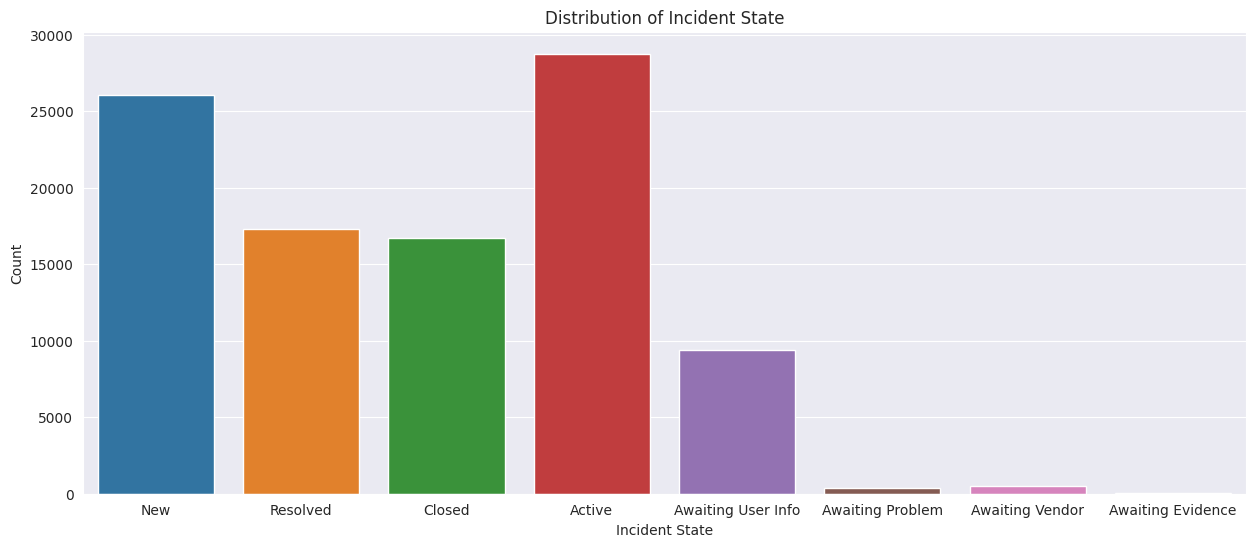

In [37]:
# Trying to figure out our target/label's distriution is it balanced or imbalanced
plt.figure(figsize=(15, 6))
sns.countplot(data=train_dataset, x='incident_state')
plt.title('Distribution of Incident State')
plt.xlabel('Incident State')
plt.ylabel('Count')
plt.show()

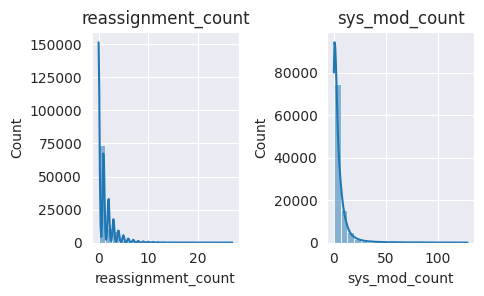

In [38]:
# Distribution of Numerical Features 
numerical_columns = ["reassignment_count","sys_mod_count"]

plt.figure(figsize=(12, 8))
for feature in numerical_columns:
    plt.subplot(3, 5, numerical_columns.index(feature) + 1)
    sns.histplot(data=train_dataset[feature], bins=20, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

<h3>Catboost Modelling</h3>

In [39]:
train_dataset.head(3)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,opened_by,opened_at,sys_updated_by,...,closed_at_dayofweek,closed_at_hour,closed_at_minute,incident_resolution_duration,incident_closure_duration,incident_resolution_duration_seconds,incident_closure_duration_seconds,active_u_priority_confirmation,sys_mod_count_reassignment_count,resolution_closure_ratio
0,INC0000045,New,True,0,0,0,True,Opened by 8,2016-02-29 01:16:00,Updated by 21,...,5,12,0,0 days 10:13:00,5 days 10:44:00,36780.0,470640.0,False,0,0.078149
1,INC0000045,Resolved,True,0,0,2,True,Opened by 8,2016-02-29 01:16:00,Updated by 642,...,5,12,0,0 days 10:13:00,5 days 10:44:00,36780.0,470640.0,False,0,0.078149
2,INC0000045,Resolved,True,0,0,3,True,Opened by 8,2016-02-29 01:16:00,Updated by 804,...,5,12,0,0 days 10:13:00,5 days 10:44:00,36780.0,470640.0,False,0,0.078149


In [40]:
train_dataset.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'opened_by', 'opened_at',
       'sys_updated_by', 'sys_updated_at', 'contact_type', 'location',
       'category', 'subcategory', 'impact', 'urgency', 'priority',
       'assignment_group', 'knowledge', 'u_priority_confirmation',
       'closed_code', 'resolved_by', 'resolved_at', 'closed_at',
       'opened_at_day', 'opened_at_dayofweek', 'opened_at_hour',
       'opened_at_minute', 'sys_updated_at_day', 'sys_updated_at_dayofweek',
       'sys_updated_at_hour', 'sys_updated_at_minute', 'resolved_at_day',
       'resolved_at_dayofweek', 'resolved_at_hour', 'resolved_at_minute',
       'closed_at_day', 'closed_at_dayofweek', 'closed_at_hour',
       'closed_at_minute', 'incident_resolution_duration',
       'incident_closure_duration', 'incident_resolution_duration_seconds',
       'incident_closure_duration_seconds', 'active_u_priority_confirmation',
       'sys_mod_c

In [41]:
cols_to_transform=['opened_by','sys_updated_by',"closed_code",'assignment_group','category','resolved_by','incident_state',
                   'subcategory','urgency','contact_type',"location",'impact','priority']
for i in cols_to_transform:
    train_dataset[i] = label_encoder.fit_transform(train_dataset[i])

<h3> Selecting cols for training</h3>

In [42]:
train_dataset.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'opened_by', 'opened_at',
       'sys_updated_by', 'sys_updated_at', 'contact_type', 'location',
       'category', 'subcategory', 'impact', 'urgency', 'priority',
       'assignment_group', 'knowledge', 'u_priority_confirmation',
       'closed_code', 'resolved_by', 'resolved_at', 'closed_at',
       'opened_at_day', 'opened_at_dayofweek', 'opened_at_hour',
       'opened_at_minute', 'sys_updated_at_day', 'sys_updated_at_dayofweek',
       'sys_updated_at_hour', 'sys_updated_at_minute', 'resolved_at_day',
       'resolved_at_dayofweek', 'resolved_at_hour', 'resolved_at_minute',
       'closed_at_day', 'closed_at_dayofweek', 'closed_at_hour',
       'closed_at_minute', 'incident_resolution_duration',
       'incident_closure_duration', 'incident_resolution_duration_seconds',
       'incident_closure_duration_seconds', 'active_u_priority_confirmation',
       'sys_mod_c

In [43]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, KFold
from imblearn.over_sampling import  RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE,ADASYN

X= train_dataset.drop(["incident_state", "contact_type","knowledge","number","made_sla",'incident_resolution_duration', 'incident_closure_duration'], axis=1)
y= train_dataset["incident_state"]
params={
    'random_state':42
}
fold_pred = []
oof_pred = []

fold = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
ros=RandomOverSampler(sampling_strategy = 'minority',random_state=42)
# Fit and resample the data
X, y = ros.fit_resample(X, y)
for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = catt.CatBoostClassifier(bootstrap_type='Bernoulli', **params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=200, verbose=False)
    preds = model.predict_proba(X_test)
    print("F1-score:", f1_score(y_test, preds.argmax(axis=1), average='weighted'))
    oof_pred.append(f1_score(y_test, preds.argmax(axis=1), average='weighted'))

print("Mean F1-score:", np.mean(oof_pred))


F1-score: 0.86515588922764
F1-score: 0.8675618951041238
F1-score: 0.8683129756593904
F1-score: 0.8639584030416468
F1-score: 0.8677882308038467
Mean F1-score: 0.8665554787673295


In [44]:
def get_catt_varimp(model, train_columns, max_vars=350):
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T
    cv_varimp_df.columns = ['feature_name', 'varimp (%)']
    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)
    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]
    return cv_varimp_df

# **XGBoost Model**

In [45]:

X= train_dataset.drop(["incident_state", "contact_type","knowledge","number","made_sla",'incident_resolution_duration','incident_closure_duration_seconds','active_u_priority_confirmation','sys_mod_count_reassignment_count','resolution_closure_ratio' ,'incident_closure_duration','opened_at', 'sys_updated_at', 'resolved_at', 'closed_at'], axis=1)
y= train_dataset["incident_state"]

fold_pred = []
oof_pred = []
fold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
params = {'max_depth': 15,
     'learning_rate': 0.08518676266060594,
     'min_child_weight': 10,
     'subsample': 0.9947774999374831,
     'colsample_bytree': 0.500152299492908,
     'reg_lambda': 0.07976878044885538,
     'reg_alpha': 2.993309377868677,
     'n_estimators': 970,
     'objective': 'multi:softprob',
#      'tree_method':'gpu_hist'
         }
ros=RandomOverSampler(sampling_strategy = 'minority',random_state=42)
X, y = ros.fit_resample(X, y)
for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_model = xgb.XGBClassifier(**params,random_state=42)
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)],verbose=False)
    xgb_preds = xgb_model.predict_proba(X_test)
    f1 = f1_score(y_test, xgb_preds.argmax(axis=1), average='weighted')
    print("F1-score:", f1)
    oof_pred.append(f1)
print("Mean F1-score:", np.mean(oof_pred))


F1-score: 0.8827464261936115
F1-score: 0.8793472886542096
F1-score: 0.8841044593937912
F1-score: 0.8816293988146133
F1-score: 0.8820935951326099
Mean F1-score: 0.8819842336377672


In [46]:
get_catt_varimp(xgb_model,X.columns)

,feature_name,varimp (%)
0,active,79.527214
13,u_priority_confirmation,13.933606
2,reopen_count,1.087462
3,sys_mod_count,0.672566
32,incident_resolution_duration_seconds,0.510124
10,urgency,0.505808
5,sys_updated_by,0.373964
1,reassignment_count,0.347372
11,priority,0.318976
31,closed_at_minute,0.254868


# **LGBM Model**

In [47]:
# tuned parameters
lgbm_params = {
    'max_depth': 9,
    'learning_rate': 0.3200141472824334,
    'num_leaves': 202,
    'min_child_weight': 1,
    'subsample': 0.9476998384656028,
    'colsample_bytree': 0.9290028087260136,
    'reg_lambda': 8.991415916802183,
    'reg_alpha': 1.8944445215473489,
    'tree_method': 'gpu_hist', 
    'random_state': 42,
    'verbose':-1,
    'metric': 'multi_logloss',
    'objective': 'multiclass',
}

X = train_dataset.drop(["incident_state", "contact_type", "knowledge", "number", "made_sla", 'incident_resolution_duration', 'incident_closure_duration', 'opened_at', 'sys_updated_at', 'resolved_at', 'closed_at'], axis=1)
y = train_dataset["incident_state"]

oof_pred = []
fold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
ros=RandomOverSampler(sampling_strategy = 'minority',random_state=42)
X, y = ros.fit_resample(X, y)
for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train the LightGBM model
    lgb_model = lgb.LGBMClassifier(**lgbm_params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    lgb_preds = lgb_model.predict_proba(X_test)
    f1 = f1_score(y_test, lgb_preds.argmax(axis=1), average='weighted')
    print("F1-score:", f1)
    oof_pred.append(f1)
mean_f1_score = np.mean(oof_pred)
print(f"Mean F1 Score: {mean_f1_score}")

F1-score: 0.8771481001891221
F1-score: 0.8769949776564204
F1-score: 0.8809713308367251
F1-score: 0.878984679873013
F1-score: 0.8780461799418338
Mean F1 Score: 0.8784290536994227


# **LGBM and XGBoost Blend**

In [48]:
# Blend predictions with different weights
blended_preds_weighted = (lgb_preds * 0.4 + xgb_preds * 0.6)
blended_f1_weighted = f1_score(y_test, np.argmax(blended_preds_weighted, axis=1), average='weighted')
print("Weighted Blended F1-score:", blended_f1_weighted)


Weighted Blended F1-score: 0.8810827014963154


In [49]:
from sklearn.metrics import accuracy_score
y_pred_labels = np.argmax(blended_preds_weighted, axis=1)
acc = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {acc:.2f}")


Accuracy: 0.88
